In [2]:
#quickstart
from pathlib import Path
import pandas as pd
from bids import BIDSLayout
from joblib import Parallel, delayed
import nilearn
import nibabel as nib
import nltools.prefs as prf
from nilearn import datasets, image, plotting, input_data
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, index_img
import numpy as np
import matplotlib.pylab as plt

import rpy2
from rpy2.robjects.packages import importr
from pymer4 import Lmer
psych = importr('psych')


import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

import os
import glob
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from nltools.stats import fdr, one_sample_permutation
from copy import deepcopy
from nltools.utils import get_anatomical
import nltools.plotting as nlplt
from datetime import date
from joblib import Parallel, delayed

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

#dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_11272019.csv') 
#atlas = image.load_img('/data/MBDU/midla/notebooks/campcc/hox_msdl_atlas.nii.gz')
#sub1 = image.load_img('/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmrip

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

In [3]:
dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_12092019.csv')
included_subjects = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/included_subjects.csv',index_col = 0)
dat_paths = dat_paths[dat_paths['subject'].isin(included_subjects['SDAN'])]
dat_paths = dat_paths.loc[dat_paths[dat_paths.columns[4:6]].duplicated(keep='last') == False]
single_ses_subs = dat_paths.loc[dat_paths.session.astype(int) <= 4, :].groupby('subject').session.nunique().reset_index().query('session <= 2').subject
dat_ind = ~dat_paths.subject.isin(single_ses_subs) & (dat_paths.session.astype(int) <= 4)
dat_paths = dat_paths.loc[dat_ind]

In [4]:
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')
basc64 = basc['scale064']
atlas = image.load_img(basc64)

atlas_dat = atlas.get_fdata()
uvs = np.unique(atlas_dat)
atlas_in_4d = []
for uv in uvs:
    atlas_in_4d.append((atlas_dat == uv).astype(int))
atlas_4d_dat = np.array(atlas_in_4d)

for _,row in dat_paths.iterrows():
    break
    
img = image.load_img(row.scaled_path)
regions_extracted_img = image.new_img_like(img,atlas_4d_dat,copy_header=False)
regions_extracted_img = resample_to_img(regions_extracted_img,img)

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int64 to float64
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [48]:
img = image.load_img(row.scaled_path)
if img.get_fdata().shape[-1] < 100:
    print('failed')
# load subjects grey matter mask
mask_img = resample_to_img(image.load_img(row.mask_path),img)
mask_dat = mask_img.get_fdata()[:,:,:,np.newaxis]

# make a binary grey matter mask
mask_bin = mask_dat > 0

# mask the regions image by the subject grey matter
regions_masked_dat = regions_extracted_img.get_fdata() * mask_bin
regions_masked_img = image.new_img_like(regions_extracted_img, 
                                        regions_masked_dat, 
                                        affine=regions_extracted_img.affine, 
                                        copy_header=True)

In [61]:
def gm_complex(row, regions_extracted_img, n_dummy=4, **kwargs):
    #Complex extraction
    

    # create a new masker instance
    masker = input_data.NiftiMapsMasker(regions_masked_img, resampling_target="data", **kwargs)

    gm_dat = mask_dat * img.get_fdata()
    gm_img = image.new_img_like(img, gm_dat, affine=img.affine, copy_header=True)
    
    # Load confounds and remove drift columns if present
#     try:
#         cfds = pd.read_csv(row.confounds_path, sep='\t')
#         cfds = cfds.loc[:, cfds.columns[0:8]]
#         return masker.fit_transform(gm_img, cfds.values)[n_dummy:, :]
#     except KeyError:
    return masker.fit_transform(gm_img)[n_dummy:, :]

In [62]:
for _,row in dat_paths.iterrows():
    break
complex_gm = gm_complex(row,regions_extracted_img, t_r=2, detrend=False,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1, standardize='psc')

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/nilearn/input_data/nifti_maps_masker.py:326: UserWarning: Persisting input arguments took 20.16s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


In [56]:
complex_gm

array([[ 7.53940874e+00, -8.26343930e+00, -6.47520237e-01, ...,
        -1.93764349e+00,  5.92050421e+00,  6.25834727e+13],
       [ 5.81270261e+00, -6.68549723e+00, -5.38867483e-01, ...,
        -1.56445210e+00,  4.86104335e+00,  5.06633977e+13],
       [ 5.36990885e+00, -6.14738873e+00, -5.04080671e-01, ...,
        -1.22516732e+00,  4.35427430e+00,  4.72891635e+13],
       ...,
       [-1.04557081e+00, -1.20733944e-01,  1.27312663e-02, ...,
         1.28046525e-01,  1.99616525e-01,  5.55654773e+11],
       [-5.28790210e-01, -1.97442527e-01,  3.37875287e-04, ...,
         1.61573212e-01,  8.81622229e-02,  6.58259951e+10],
       [-6.94918113e-03, -6.96130906e-02, -6.42429651e-03, ...,
         5.82838291e-02, -7.27533537e-03, -3.27680827e+10]])

In [28]:
#Simple
#Function: takes in row and masker object
#Returns image masked by grey matter, confounds, and transformed to atlas masker
def gm_simple(row, regions_extracted_img, n_dummy=4, **kwargs):
    img = image.load_img(row.scaled_path)
    img_dat = img.get_fdata()
    if img_dat.shape[-1] < 100:
        print('failed')
    
    # load subjects grey matter mask
    mask_img = resample_to_img(image.load_img(row.mask_path),img)
    mask_dat = mask_img.get_fdata()[:,:,:,np.newaxis]
    mask_bin = mask_dat > 0
    
    regions_masked_dat = regions_extracted_img.get_fdata() * mask_bin
    regions_masked_img = image.new_img_like(regions_extracted_img, 
                                            regions_masked_dat, 
                                            affine=regions_extracted_img.affine, 
                                            copy_header=True)
    
    gm_dat = mask_dat * (img_dat - 100)
    simple_masked_ts = np.zeros((img_dat.shape[-1], regions_masked_dat.shape[-1]))
    
    for yi in range(simple_masked_ts.shape[-1]):
        simple_masked_ts[:,yi] = (((gm_dat * regions_masked_dat[:,:,:,yi][:,:,:,np.newaxis]).sum(0).sum(0).sum(0))/regions_masked_dat[:,:,:,yi].sum() + 100)
    return simple_masked_ts

In [38]:
#Simple
#Function: takes in row and masker object
#Returns image masked by grey matter, confounds, and transformed to atlas masker
def gm_simple100(row, regions_extracted_img, n_dummy=4, **kwargs):
    img = image.load_img(row.scaled_path)
    img_dat = img.get_fdata()
    if img_dat.shape[-1] < 100:
        print('failed')
    
    # load subjects grey matter mask
    mask_img = resample_to_img(image.load_img(row.mask_path),img)
    mask_dat = mask_img.get_fdata()[:,:,:,np.newaxis]
    mask_bin = mask_dat > 0
    
    regions_masked_dat = regions_extracted_img.get_fdata() * mask_bin
    regions_masked_img = image.new_img_like(regions_extracted_img, 
                                            regions_masked_dat, 
                                            affine=regions_extracted_img.affine, 
                                            copy_header=True)
    
    gm_dat = mask_dat * (img_dat)
    simple_masked_ts = np.zeros((img_dat.shape[-1], regions_masked_dat.shape[-1]))
    
    for yi in range(simple_masked_ts.shape[-1]):
        simple_masked_ts[:,yi] = (((gm_dat * regions_masked_dat[:,:,:,yi][:,:,:,np.newaxis]).sum(0).sum(0).sum(0))/regions_masked_dat[:,:,:,yi].sum())
    return simple_masked_ts

In [39]:
for _,row in dat_paths.iterrows():
    break
simple_gm100 = gm_simple100(row,regions_extracted_img, t_r=2, detrend=False,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)

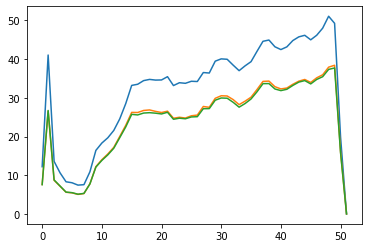

In [43]:
plt.plot(simple_gm100[0])
plt.plot(simple_gm100[1])
plt.plot(simple_gm100[2])

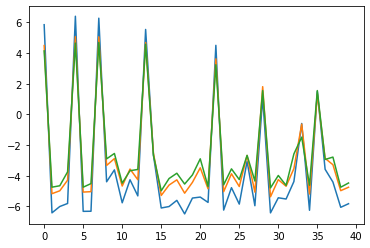

In [63]:
plt.plot(complex_gm[0][:40])
plt.plot(complex_gm[1][:40])
plt.plot(complex_gm[2][:40])

In [33]:
simple_gm

array([[104.34806306, 113.9152256 , 104.72198975, ..., 113.6868623 ,
        104.17131957,  99.99999904],
       [ 99.74872631,  99.41766692,  99.82410167, ..., 102.84433176,
        100.33420323,  99.99999977],
       [ 99.70800025,  99.58639013,  99.92745004, ..., 102.14322439,
        100.09033876,  99.99999984],
       ...,
       [101.17405573, 100.75068431, 100.24562136, ...,  98.78390066,
         99.71009219, 100.00000011],
       [101.79495885, 100.41544691, 100.19075456, ...,  98.97486623,
         99.75573884, 100.0000001 ],
       [102.65032154, 100.9264471 , 100.31610513, ...,  98.91292703,
         99.62544881, 100.00000011]])

In [34]:
complex_gm

array([[ 7.53940874e+00, -8.26343930e+00, -6.47520237e-01, ...,
        -1.93764349e+00,  5.92050421e+00,  6.25834727e+13],
       [ 5.81270261e+00, -6.68549723e+00, -5.38867483e-01, ...,
        -1.56445210e+00,  4.86104335e+00,  5.06633977e+13],
       [ 5.36990885e+00, -6.14738873e+00, -5.04080671e-01, ...,
        -1.22516732e+00,  4.35427430e+00,  4.72891635e+13],
       ...,
       [-1.04557081e+00, -1.20733944e-01,  1.27312663e-02, ...,
         1.28046525e-01,  1.99616525e-01,  5.55654773e+11],
       [-5.28790210e-01, -1.97442527e-01,  3.37875287e-04, ...,
         1.61573212e-01,  8.81622229e-02,  6.58259951e+10],
       [-6.94918113e-03, -6.96130906e-02, -6.42429651e-03, ...,
         5.82838291e-02, -7.27533537e-03, -3.27680827e+10]])

In [27]:
simple_gm.shape

(97, 115, 97, 366)